In [4]:
# Assignment 2.4) Minimum Lap Time Optimization for an Electric Race Car

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cvxpy as cp
from matplotlib.collections import LineCollection

plt.rcParams['text.usetex'] = True

In [6]:
# Load data from MATLAB file
data = scipy.io.loadmat('Ex4Data.mat')
par = data['par'][0, 0]

N = par['Distance'].shape[1]
ds = par['Distance'][0,1] - par['Distance'][0,0]

# Scaling factors
s_E_k = par['E_max'].max()
s_v = (np.sqrt(s_E_k * 2 / par['m']))[0, 0]
s_dt = ds/50
s_F_drag = (0.5 * par['rho'] * par['A_f'] * par['c_d'] * s_v ** 2)[0, 0]
s_F_p = par['F_max'][0, 0]
s_F_brk = 1e4

# --Optimization variables--
# State variable
E_k = cp.Variable((1, N))  # Kinetic energy, J
# Input variables
F_p = cp.Variable((1, N))  # Propulsive force, N
F_brk = cp.Variable((1, N))  # Braking force, N
# Lifting variables
dt = cp.Variable((1, N))  # Time per quantized distance, s
v = cp.Variable((1, N))  # Velocity, m/s
F_drag = cp.Variable((1, N))  # Drag force, N

# Objective
objective = cp.sum(dt) * s_dt

# Define constraints
constraints = [
    # Longitudinal force balance, discretized with the trapezoidal method
    E_k[0, 1:] - E_k[0, :-1] == 1 / s_E_k * (0.5 * (F_p[0, :-1] * s_F_p - F_drag[0, :-1] * s_F_drag - F_brk[0, :-1] * s_F_brk + F_p[0, 1:] * s_F_p - F_drag[0, 1:] * s_F_drag - F_brk[0, 1:] * s_F_brk) * ds),
    # Aerodynamic drag force
    F_drag == par['rho'][0, 0] * par['c_d'][0, 0] * par['A_f'][0, 0] * E_k * s_E_k / par['m'][0, 0] / s_F_drag,
    # Kinetic energy
    E_k >= 0.5 * par['m'][0, 0] * (v * s_v) ** 2 / s_E_k,
    # Continuity
    E_k[0, 0] == E_k[0, -1],
    # Propulsion force bounds
    F_p <= par['F_max'][0, 0] / s_F_p,
    F_p <= par['P_max'][0, 0] * dt * s_dt / ds / s_F_p,
    F_p >= 0,
    # Maximum kinetic energy
    E_k <= 1 / s_E_k * par['E_max'],
    # Braking direction
    F_brk >= 0
]

# Lethargy constraint
for i in range(N):
    constraints.append(
        cp.SOC(v[0, i] + dt[0, i] * s_dt / ds, cp.vstack([2 / np.sqrt(s_v), v[0, i] - dt[0, i] * s_dt / ds]))
    )

# Run optimization
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve(solver=cp.MOSEK, verbose=True)

# Print optimal values
print("Optimal value of dt:", dt.value)
print("Optimal value of v:", v.value)



                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Feb 17 02:58:57 PM: Your problem has 6408 variables, 9612 constraints, and 0 parameters.
(CVXPY) Feb 17 02:58:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 17 02:58:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 17 02:58:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 17 02:58:57 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 17 02:58:57 PM: Compiling problem (target solver=MOSEK)

/Users/leonardopedroso/Documents/Research/Teaching/4DM20 EngOpt/2025/Computer Assignments/ComputerAssignment2/ComputerAssignment2.withSolutions/python/.venv/lib/python3.10/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/Users/leonardopedroso/Documents/Research/Teaching/4DM20 EngOpt/2025/Computer Assignments/ComputerAssignment2/ComputerAssignment2.withSolutions/python/.venv/lib/python3.10/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/Users/leonardopedroso/Documents/Research/Teaching/4DM20 EngOpt/2025/Computer Assignments/ComputerAssignment2/ComputerAssignment2.withSolutions/python/.venv/lib/python3.10/site-packages/mosek/__in

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Feb 17 02:58:59 PM: Problem status: optimal
(CVXPY) Feb 17 02:58:59 PM: Optimal value: 8.434e+01
(CVXPY) Feb 17 02:58:59 PM: Compilation took 1.333e+00 seconds
(CVXPY) Feb 17 02:58:59 PM: Solver (including time spent in interface) took 1.994e-01 seconds
Optimal value of dt: [[0.67434644 0.67359574 0.67285068 ... 0.67586535 0.67510291 0.67434644]]
Optimal value of v: [[0.72635174 0.72716126 0.72796648 ... 0.72471934 0.72553783 0.72635174]]


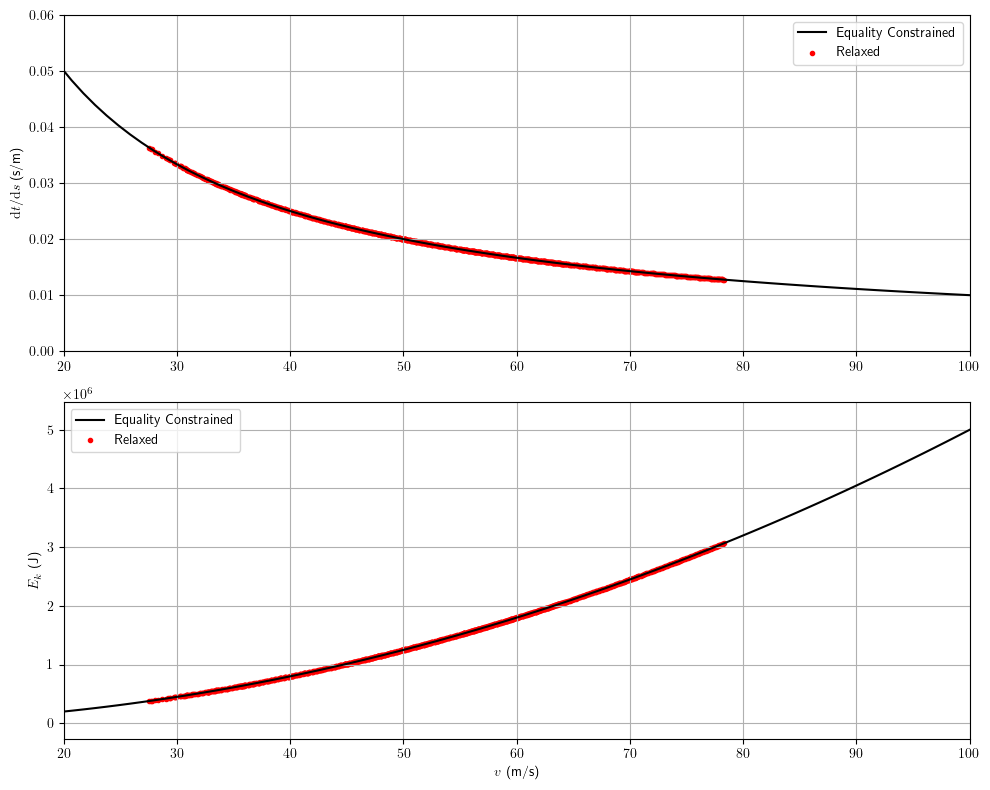

In [7]:
# Plots
velocityVector = np.linspace(0.1, np.sqrt(par['E_max'].max() / par['m'][0, 0] * 2), 100)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(velocityVector, 1 / velocityVector, 'k', label='Equality Constrained')
plt.scatter(v.value * s_v, dt.value / ds * s_dt,
            marker='.', c='r', label='Relaxed')
plt.ylim([0, 0.06])
plt.xlim([20, 100])
plt.ylabel('$\mathrm{d}t/\mathrm{d}s$ (s/m)')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
plt.plot(velocityVector, par['m'][0, 0] * 0.5 * velocityVector ** 2, 'k', label='Equality Constrained')
plt.scatter(v.value * s_v, E_k.value * s_E_k,
            marker='.', c='r', label='Relaxed')
plt.ylabel('$E_k$ (J)')
plt.xlabel('$v$ (m/s)')
plt.xlim([20, 100])
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

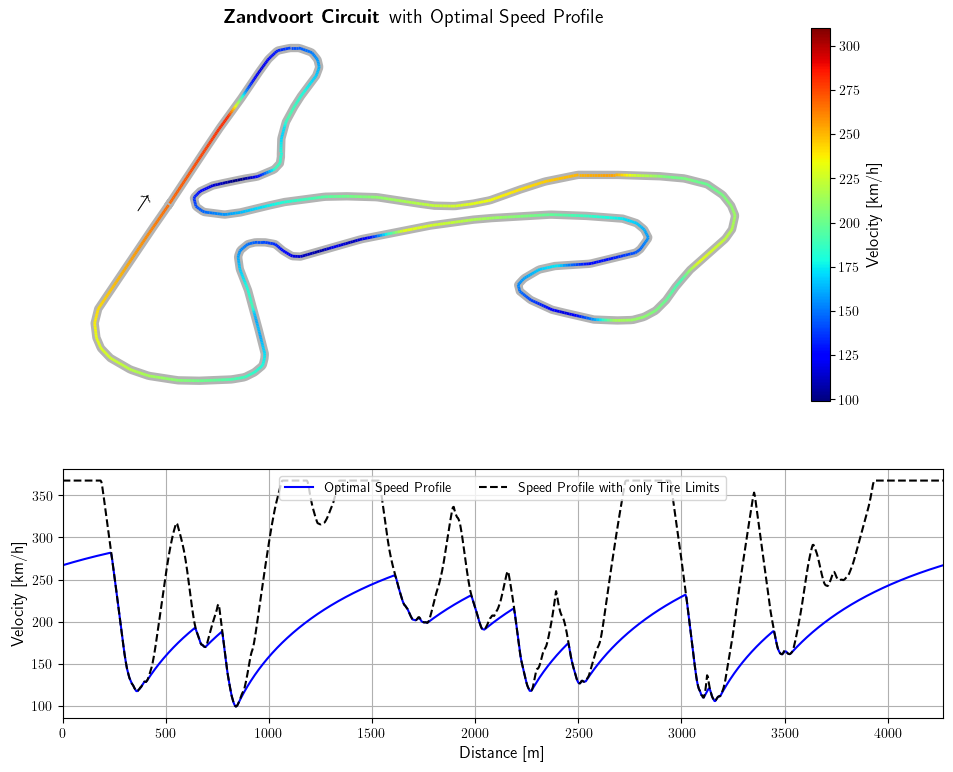

In [8]:
zand_x = par['zandvoort'][0, :]  # x-coordinates
zand_y = par['zandvoort'][1, :]  # y-coordinates
distance = par['Distance']       # distance array used for the lower plot

# Compute the optimal speed profile in km/h
v_opt = v.value.flatten() * s_v * 3.6  # shape: (N,)

# Compute tire-limit speed (assuming par['E_max'] and par['m'] are scalars or single valued arrays)
tire_speed = np.sqrt(2 * par['E_max'] / par['m'][0, 0]) * 3.6

# Determine color limits for the top (track) plot
min_speed = np.sqrt(2 * np.min(par['E_max']) / par['m'][0,0]) * 3.6  # lower limit
max_speed = 1.1 * np.max(v_opt)  # upper limit

# Create segments for the colored line along the circuit using the zandvoort coordinates.
points = np.array([zand_x, zand_y]).T  # shape: (N, 2)
# Create segments connecting consecutive points.
segments = np.array([points[:-1], points[1:]]).transpose(1, 0, 2)
# Use the average speed on each segment for the color.
v_seg = (v_opt[:-1] + v_opt[1:]) / 2

# Create figure with two subplots using gridspec with height ratios 3:2 (similar to tiledlayout of 5 rows:3 and 2)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),
                               gridspec_kw={'height_ratios': [3, 2]})
plt.tight_layout(pad=3)

# --- Top subplot: Circuit view with optimal speeds ---

# Plot the background track in thick gray (similar to MATLAB's plot with linewidth=6)
ax1.plot(zand_x, zand_y, color=[0.7, 0.7, 0.7], linewidth=6)

# Create a LineCollection (no face color, using edge colors) to mimic MATLAB's surface with 'edgecol','interp'
lc = LineCollection(segments, cmap='jet', norm=plt.Normalize(min_speed, max_speed), linewidth=2)
lc.set_array(v_seg)  # assign colors based on speed
line = ax1.add_collection(lc)

# Add a colorbar.
cbar = fig.colorbar(line, ax=ax1)
cbar.set_label('Velocity [km/h]', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Add an arrow/text at the start of the circuit (similar to MATLAB's text command)
# Compute an angle based on the first segment.
dx = zand_x[1] - zand_x[0]
dy = zand_y[1] - zand_y[0]
angle_deg = np.degrees(np.arctan2(dy, dx))
ax1.text(zand_x[0]-5e-4, zand_y[0], r'$\rightarrow$', fontsize=16,
         rotation=angle_deg, va='center', ha='center')

# Format the top plot.
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title(r'\textbf{Zandvoort Circuit}$\,$ with Optimal Speed Profile', fontsize=14)

# --- Bottom subplot: Speed profiles along the Distance ---
ax2.plot(distance.flatten(), v_opt, label='Optimal Speed Profile', color='b')
# If the tire-limit speed is constant, plot a dashed line.
ax2.plot(distance.flatten(), tire_speed.flatten(),
         'k--', label='Speed Profile with only Tire Limits')

ax2.set_xlim([0, distance.flatten()[-1]])
ax2.grid(True)
ax2.set_xlabel('Distance [m]', fontsize=12)
ax2.set_ylabel('Velocity [km/h]', fontsize=12)
ax2.legend(loc='upper center', ncol=2)
# For LaTeX rendering in tick labels
plt.rcParams['text.usetex'] = True

plt.show()